# 1724T006モータの台形制御の応答

2020/2/11

まずはnumpyやmatplotlibモジュールのインポート

そして、モータの各種諸元を設定します。

PIコントローラの比例ゲインと積分ゲインをここで設定しています。

In [37]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

#1724DCモータの諸元
R=3.41
K=6.59e-3
L=75e-6
D=1.4e-7
J=1e-7

#コントローラのゲイン
Kp=0.1
Ki=100.0


続いて応答を計算するための閉ループ伝達関数の分母と分子の多項式をpoly1d()を使って定義します。
- Dcom：共通の分母
- No:角速度の分子
- Nu:制御入力の分母
- Ne:誤差の分子

In [38]:
#閉ループ伝達関数の分子と分母
Dcom=np.poly1d([J*L, D*L+J*R, D*R+K**2+K*Kp, K*Ki])
No=np.poly1d([K*Kp, K*Ki])
Nu=np.poly1d([Kp, Ki])*np.poly1d([J*L, D*L+J*R, D*R+K**2])
Ne=np.poly1d([J*L, D*L+J*R, D*R+K**2, 0])

極を計算します！

In [39]:
#極の計算
p=Dcom.r

以下では応答式の係数を求める値ごとに分けて計算しています。

In [40]:
#角速度の応答式係数
ko1=No(p[0])/Dcom.deriv()(p[0])/p[0]/p[0]
ko2=No(p[1])/Dcom.deriv()(p[1])/p[1]/p[1]
ko3=No(p[2])/Dcom.deriv()(p[2])/p[2]/p[2]
ko42=No(0)/Dcom(0)
ko41=(No.deriv()(0)*Dcom(0)-No(0)*Dcom.deriv()(0))/(Dcom(0)**2)

In [41]:
#制御入力の応答式係数
ku1=Nu(p[0])/Dcom.deriv()(p[0])/p[0]/p[0]
ku2=Nu(p[1])/Dcom.deriv()(p[1])/p[1]/p[1]
ku3=Nu(p[2])/Dcom.deriv()(p[2])/p[2]/p[2]
ku42=Nu(0)/Dcom(0)
ku41=(Nu.deriv()(0)*Dcom(0)-Nu(0)*Dcom.deriv()(0))/(Dcom(0)**2)

In [42]:
#誤差の応答式係数
ke1=Ne(p[0])/Dcom.deriv()(p[0])/p[0]/p[0]
ke2=Ne(p[1])/Dcom.deriv()(p[1])/p[1]/p[1]
ke3=Ne(p[2])/Dcom.deriv()(p[2])/p[2]/p[2]
ke42=Ne(0)/Dcom(0)
ke41=(Ne.deriv()(0)*Dcom(0)-Ne(0)*Dcom.deriv()(0))/(Dcom(0)**2)

いよいよ、応答を計算します。

本記事では、まず最初に、単位ランプ応答を計算します。

In [59]:
#応答計算
starttime=0.0
endtime=1.0
points=10000

t=np.linspace(starttime, endtime, points)

omega1=ko1*np.exp(p[0]*t) + ko2*np.exp(p[1]*t) + ko3*np.exp(p[2]*t) + ko42*t + ko41 
omega1=omega1.real

u1=ku1*np.exp(p[0]*t) + ku2*np.exp(p[1]*t) + ku3*np.exp(p[2]*t) + ku42*t + ku41 
u1=u1.real

e1=ke1*np.exp(p[0]*t) + ke2*np.exp(p[1]*t) + ke3*np.exp(p[2]*t) + ke42*t + ke41 
e1=e1.real

適切にランプ応答を遅らせる必要があります。コードが汚くなるので、遅らせる関数を作りました。

In [50]:
#出力を遅らせる関数
def shift(x, s):
    l=len(x)
    x=np.roll(x, s)
    dummy_ones =np.ones(l-s)
    dummy_zeros=np.zeros(s)
    dummy=np.concatenate([dummy_zeros,dummy_ones],0)
    return x*dummy

ランプ応答から台形入力に対する応答を合成するには４つのランプ応答を合成する必要があります。

以下で、それをしています。

また、単位ランプ応答ではなく、大きさを持ったランプ入力を計算すため、出力は適宜定数倍します。

In [60]:
#出力を遅らせて合成
omega2=shift(omega1,int(points/4))
omega3=shift(omega1,int(2*points/4))
omega4=shift(omega1,int(3*points/4))
omega=omega1-omega2-omega3+omega4
omega=1000*omega

u2=shift(u1,int(points/4))
u3=shift(u1,int(2*points/4))
u4=shift(u1,int(3*points/4))
u=u1-u2-u3+u4
u=1000*u

e2=shift(e1,int(points/4))
e3=shift(e1,int(2*points/4))
e4=shift(e1,int(3*points/4))
e=e1-e2-e3+e4
e=1000*e


あとは可視化です。

<IPython.core.display.Javascript object>


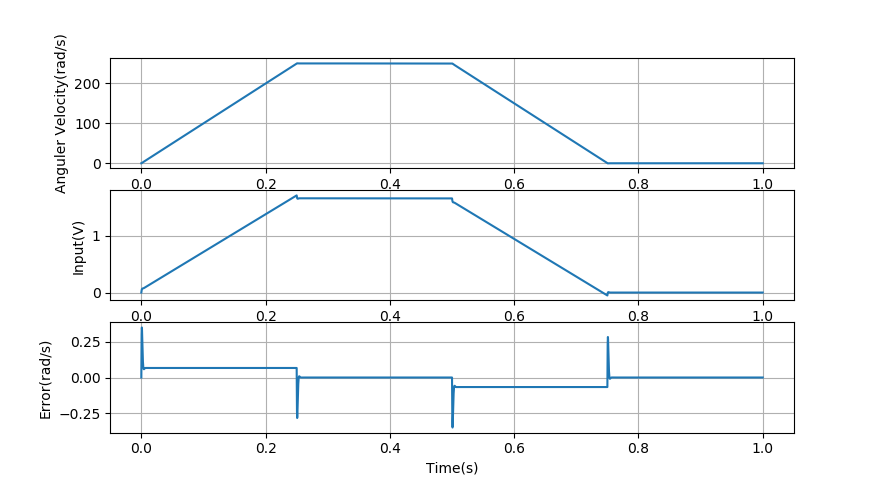

In [57]:
plt.figure()
plt.subplot(311)
plt.plot(t, omega)
plt.grid()
plt.ylabel('Anguler Velocity(rad/s)')

plt.subplot(312)
plt.plot(t, u)
plt.grid()
plt.ylabel('Input(V)')

plt.subplot(313)
plt.plot(t, e)
plt.grid()
plt.ylabel('Error(rad/s)')
plt.xlabel('Time(s)')
plt.show()

In [66]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.layouts import column
output_notebook()

Loading BokehJS ...

In [67]:
# create three plots
s1 = figure(background_fill_color="#fafafa", plot_width=700, plot_height=200)
s1.line(t, omega, line_width=2, color="#53777a")

s2 = figure(background_fill_color="#fafafa", plot_width=700, plot_height=200)
s2.line(t, u, line_width=2, color="#c02942")

s3 = figure(background_fill_color="#fafafa", plot_width=700, plot_height=200)
s3.line(t, e, line_width=2, color="#d95b43")

# make a grid
#grid = gridplot([[s1], [s2], [s3]], plot_width=700, plot_height=200)

show(column(s1, s2, s3))
